In [67]:
import pandas as pd
from collections import Counter
import numpy as np

# Load the NRC lexicon
nrc_lexicon = pd.read_csv('/Users/faraznaqvi/Downloads/NRC-Emotion-Lexicon 2/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt', sep='\t', header=None)
nrc_lexicon.columns = ['word', 'emotion', 'association']
nrc_lexicon = nrc_lexicon[nrc_lexicon['association'] == 1]

# Sample text data
texts = [
    "I am very happy and joyful but also a bit sad and fearful.",
    "The project failed miserably and everyone was angry.",
    "I am looking forward to the new opportunities with anticipation and trust.",
    "He felt a wave of sadness wash over him as he remembered the past.",
    "Her surprise and joy were evident when she received the news.",
    "The disgusting smell made him feel nauseous.",
    "Fear gripped her as she walked down the dark alley.",
    "Trust in others is essential for a harmonious community.",
    "I anticipate a bright future filled with endless possibilities.",
    "The negativity in the room was palpable, making everyone uncomfortable."
    " I am the life of the party.",
    "I don't talk a lot.",
    "I feel comfortable around people.",
    "I keep in the background.",
    "I start conversations.",
    "I have little to say.",
    "I talk to a lot of different people at parties.",
    "I don't like to draw attention to myself.",
    "I don't mind being the center of attention.",
    "I am quiet around strangers.",
    "I get stressed out easily.",
    "I am relaxed most of the time.",
    "I worry about things.",
    "I seldom feel blue.",
    "I am easily disturbed.",
    "I get upset easily.",
    "I change my mood a lot.",
    "I have frequent mood swings.",
    "I get irritated easily.",
    "I often feel blue.",
    "I feel little concern for others.",
    "I am interested in people.",
    "I insult people.",
    "I sympathize with others' feelings.",
    "I am not interested in other people's problems.",
    "I have a soft heart.",
    "I am not really interested in others.",
    "I take time out for others.",
    "I feel others' emotions.",
    "I make people feel at ease.",
    "I am always prepared.",
    "I leave my belongings around.",
    "I pay attention to details.",
    "I make a mess of things.",
    "I get chores done right away.",
    "I often forget to put things back in their proper place.",
    "I like order.",
    "I shirk my duties.",
    "I follow a schedule.",
    "I am exacting in my work.",
    "I have a rich vocabulary.",
    "I have difficulty understanding abstract ideas.",
    "I have a vivid imagination.",
    "I am not interested in abstract ideas.",
    "I have excellent ideas.",
    "I do not have a good imagination.",
    "I am quick to understand things.",
    "I use difficult words.",
    "I spend time reflecting on things.",
    "I am full of ideas.",
]

In [68]:
# Define mapping with regular and opposite scores
emotion_to_ocean = {
    'anger': {'N': 1, 'O': 0},
    'anticipation': {'O': 1, 'C': 1},
    'disgust': {'N': 1, 'O': 0},
    'fear': {'N': 1, 'O': 0},
    'joy': {'E': 1, 'A': 1},
    'negative': {'N': 1, 'O': 0},
    'positive': {'E': 1, 'A': 1},
    'sadness': {'N': 1, 'O': 0},
    'surprise': {'O': 1, 'C': 0},
    'trust': {'A': 1, 'C': 1}
}



In [69]:
def extract_emotion_features(text):
    tokens = text.lower().split()
    emotion_counts = Counter()
    for token in tokens:
        emotions = nrc_lexicon[nrc_lexicon['word'] == token]['emotion'].values
        emotion_counts.update(emotions)
    return emotion_counts

def generate_ocean_scores(emotion_counts, emotion_to_ocean):
    ocean_scores = {trait: 0 for trait in 'OCEAN'}
    for emotion, count in emotion_counts.items():
        for trait, weight in emotion_to_ocean.get(emotion, {}).items():
            if trait in ocean_scores:
                ocean_scores[trait] += count * weight
            else:
                # Calculate opposite trait score
                opposite_trait = trait.lower() if trait.isupper() else trait.upper()
                ocean_scores[opposite_trait] -= count * weight
    return ocean_scores

# Apply the functions to your dataset
emotion_features = [extract_emotion_features(text) for text in texts]
ocean_scores = [generate_ocean_scores(emotion, emotion_to_ocean) for emotion in emotion_features]

# Convert to DataFrame
emotion_df = pd.DataFrame(emotion_features).fillna(0)
ocean_df = pd.DataFrame(ocean_scores).fillna(0)


In [70]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

param_dist = {
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'n_estimators': randint(100, 500),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

random_search = RandomizedSearchCV(estimator=XGBRegressor(),
                                   param_distributions=param_dist,
                                   n_iter=100,
                                   scoring='neg_root_mean_squared_error',
                                   cv=5,
                                   verbose=1,
                                   random_state=42)

random_search.fit(X_train, y_train['O'])  # Example for Openness to Experience (O)

print("Best parameters found: ", random_search.best_params_)
print("Lowest RMSE found: ", -random_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'colsample_bytree': 0.7601538504518967, 'learning_rate': 0.2416955175206918, 'max_depth': 5, 'n_estimators': 405, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.9839868827199115}
Lowest RMSE found:  0.17619044731230166


In [75]:
X_train

,anticipation,joy,positive,trust,negative,sadness,fear,surprise,anger,disgust
36,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
8,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
17,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0
4,0.0,2.0,4.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
54,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
50,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0


In [76]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(emotion_df, ocean_df, test_size=0.2, random_state=42)

# Train a model for each OCEAN trait
models = {}
for trait in y_train.columns:
    model = XGBRegressor(learning_rate=0.2416955175206918, 
                         n_estimators=405, 
                         max_depth=5, 
                         subsample=0.9839868827199115, 
                         colsample_bytree=0.7601538504518967, 
                         reg_lambda= 0.1, 
                         reg_alpha= 0)
#     model = XGBRegressor()
    model.fit(X_train, y_train[trait])
    models[trait] = model

    # Evaluate the model
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test[trait], y_pred, squared=False)
    print(f'RMSE for {trait}: {rmse}')


RMSE for O: 0.09011317799701804
RMSE for C: 0.32374935948026645
RMSE for E: 0.27863886381905456
RMSE for A: 0.10303003094959905
RMSE for N: 1.1958598658028627


In [77]:
# Predict OCEAN scores and their opposites for new text
def predict_ocean(text, models, nrc_lexicon, emotion_to_ocean, feature_order):
    emotion_counts = extract_emotion_features(text)
    emotion_df = pd.DataFrame([emotion_counts]).fillna(0)

    # Ensure all emotion columns are present and in the correct order
    for emotion in feature_order:
        if emotion not in emotion_df.columns:
            emotion_df[emotion] = 0
    emotion_df = emotion_df[feature_order]

    scores = {}
    opposite_scores = {}
    
    # Predict regular OCEAN scores
    for trait, model in models.items():
        scores[trait] = model.predict(emotion_df)[0]
    
    
    
    return scores

# Example usage
text = "now a days im feeling so motived to start a new business but sometimes get confused ..will it work or not .some of the time of day i feel very dull and tired and forget many things also but want to change this and tried ti keep remeber all of them  ."
predicted_scores = predict_ocean(text, models, nrc_lexicon, emotion_to_ocean, emotion_df.columns)
print("Regular OCEAN Scores:")
print(predicted_scores)



Regular OCEAN Scores:
{'O': 1.1102374, 'C': 1.264882, 'E': 4.923984, 'A': 5.9238224, 'N': 3.798485}


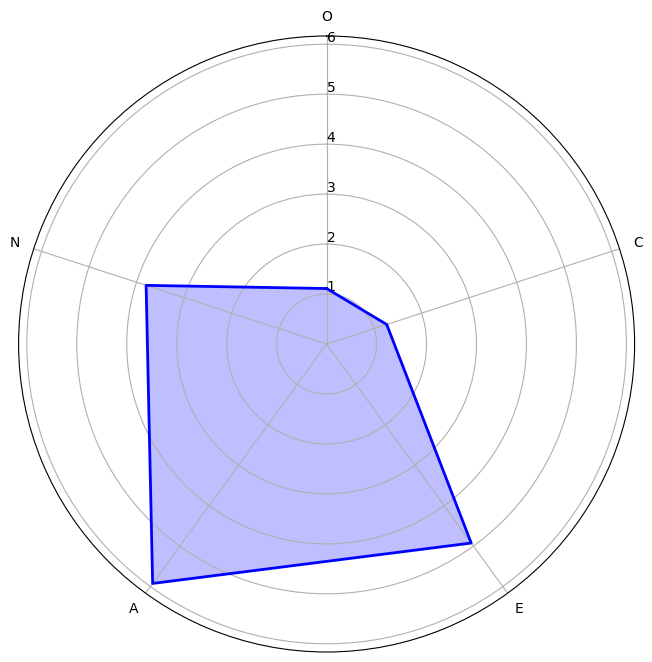

In [78]:
def plot_spider_chart(scores):
    traits = list(scores.keys())
    trait_scores = list(scores.values())
    
    # Number of traits
    num_traits = len(traits)
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    # Calculate angle for each trait
    angles = np.linspace(0, 2 * np.pi, num_traits, endpoint=False).tolist()
    angles += angles[:1]  # Complete the loop
    
    # Plot data
    ax.fill(angles, trait_scores + trait_scores[:1], color='blue', alpha=0.25)
    ax.plot(angles, trait_scores + trait_scores[:1], color='blue', linewidth=2)
    
    # Add labels
    ax.set_theta_offset(np.pi / 2)  # Rotate 90 degrees
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(0)
    plt.xticks(angles[:-1], traits)
    
    # Display plot

# Plot spider chart for predicted scores
plot_spider_chart(predicted_scores)